# Libraries

In [1]:
# import csv
# import os
# import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [2]:
# query = "Query_NYT_5y_surveillance"
query = "Query_NYT_13y_surveillance"
# query = "Query_US_5y_Svalbard"

FEATHER_FILE = query + ".feather"

df = pd.read_feather('data/' + FEATHER_FILE)
# df = df.drop(df[df['tags'].str.contains('None') == True].index)
# df = df.reset_index(drop=True)
df = df.drop('text_downloaded', axis=1)
df = df.drop('stories_id', axis=1)

df.sample()

,title,url,year,text,tags,GPE,IND,ORG
1780,‘Abbott Elementary’ and the Joys of Living Out...,https://www.nytimes.com/2023/03/29/magazine/ab...,2023,Supported by\nScreenland\n‘Abbott Elementary’ ...,"[{'label': 'television', 'score': '0.92413'}, ...","[America, South Philly, Atlanta, France]","[Ava Coleman, Abbott Elementary, Schemmenti, A...","[Abbott Elementary’, the Joys of Living Outsid..."


## IND cleaning

In [3]:
for index, row in df.iterrows():

    ind = row['IND']
    # print(ind)

    ind = [a for a in ind if (' ' in a)] # remove ind without space
    ind = [a for a in ind if ('\n' not in a)] # remove ind with \n
    # print(ind)

    df.loc[index, 'IND'] = ind



## Set tags

In [4]:
all_tags = []

for index, row in df.iterrows():

    tags = []

    for i, tag in enumerate(row["tags"]):
        if i < 3:
            tags.append(tag["label"])

    all_tags.append(tags)

df['TAG'] = all_tags
df = df.drop(columns=['tags'])

df.sample()

,title,url,year,text,GPE,IND,ORG,TAG
1115,Head of State Police Calls Response to Uvalde ...,https://www.nytimes.com/2022/06/21/us/uvalde-l...,2022,Supported by\nHead of State Police Calls Respo...,"[AUSTIN, Texas, Uvalde, Texas, Austin, Texas]","[Steven McCraw, Pete Arredondo, Greg Abbott, C...","[the Department of Public Safety, the Texas St...","[education and schools, attacks on police, chi..."


## Clean Years

In [5]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{'2012', '2019', '2016', '2017', '2018', '2023', '2014', '2022', '2021', '2011', '2010', '2013', '2020', '2015'}


## Entities

In [6]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    ind = row["IND"]
    org = row["ORG"].tolist()
    tag = row["TAG"]
    
    cooccurrences = list(ind + org + tag)

    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    for entity in tag:
        update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 37856


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
47,F.B.I.,org,2031,NaN,None,-1,-1,-1,"{'2010': 37, '2011': 24, '2012': 17, '2013': 7...",[https://www.nytimes.com/2018/12/03/nyregion/m...,[F.B.I. Raids Home of Atlantic City Mayor Fran...,"[Frank Gilliam, Frank Gilliam, Doreen Holder, ..."


# Treatment

## Normalization

In [7]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
6654,Brian H. Levin,ind,1,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2019/08/05/us/politic...,[Shootings Renew Debate Over How to Combat Dom...,"[Rod Rosenstein, Mary McCord, Timothy McVeigh,...",0.0,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


## Filter

In [29]:
# Number of rows by type

max_subjects = 100
max_orgs = 100
max_people = 200

top_ind = (
    entities_all.loc[entities_all["type"] == "ind"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_people)
)
top_org = (
    entities_all.loc[entities_all["type"] == "org"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_orgs)
)
top_tag = (
    entities_all.loc[entities_all["type"] == "tag"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_subjects)
)

entities = pd.concat([top_ind, top_org, top_tag])

# min_frequency = 15

# entities = (
#     entities_all[entities_all['frequency']>min_frequency]
#     .sort_values(by=["frequency"], ascending=False)
# )

len(entities)


400

In [30]:
entities.head(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2818,Vladimir V. Putin,ind,539,NaN,None,-1,-1,-1,"{'2010': 1, '2011': 0, '2012': 2, '2013': 6, '...",[https://www.nytimes.com/2019/01/15/us/politic...,[Trump and Putin Have Met Five Times. What Was...,"[Andrew S. Weiss, Bill Clinton, Robert S. Muel...",0.265025,"{""2010"": 1, ""2011"": 0, ""2012"": 2, ""2013"": 6, ""..."
5410,Volodymyr Zelensky,ind,484,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2019/06/24/technology...,[Chinese Drones Made in America: One Company’s...,"[Xi Jinping, Xi Jinping, Vladimir Putin, Mario...",0.237931,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."
0,Xi Jinping,ind,448,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 12, ...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Xi Jinping, Mike Pence, Mike Pompeo, George H...",0.220197,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 12, ..."


## Linear Regression

In [31]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
1071,Michael Brown,ind,32,-0.989868,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2019/01/14/nyregion/n...,[Did the Police Spy on Black Lives Matter Prot...,"[Eric Garner, Arlene Bluth, John J. Miller, Bo...",0.015271,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


## Colors

In [32]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2818,Vladimir V. Putin,ind,539,11.447495,#b40426,-1,-1,-1,"{'2010': 1, '2011': 0, '2012': 2, '2013': 6, '...",[https://www.nytimes.com/2019/01/15/us/politic...,[Trump and Putin Have Met Five Times. What Was...,"[Andrew S. Weiss, Bill Clinton, Robert S. Muel...",0.265025,"{""2010"": 1, ""2011"": 0, ""2012"": 2, ""2013"": 6, ""..."


# Embedding

## Term Frequency

In [33]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

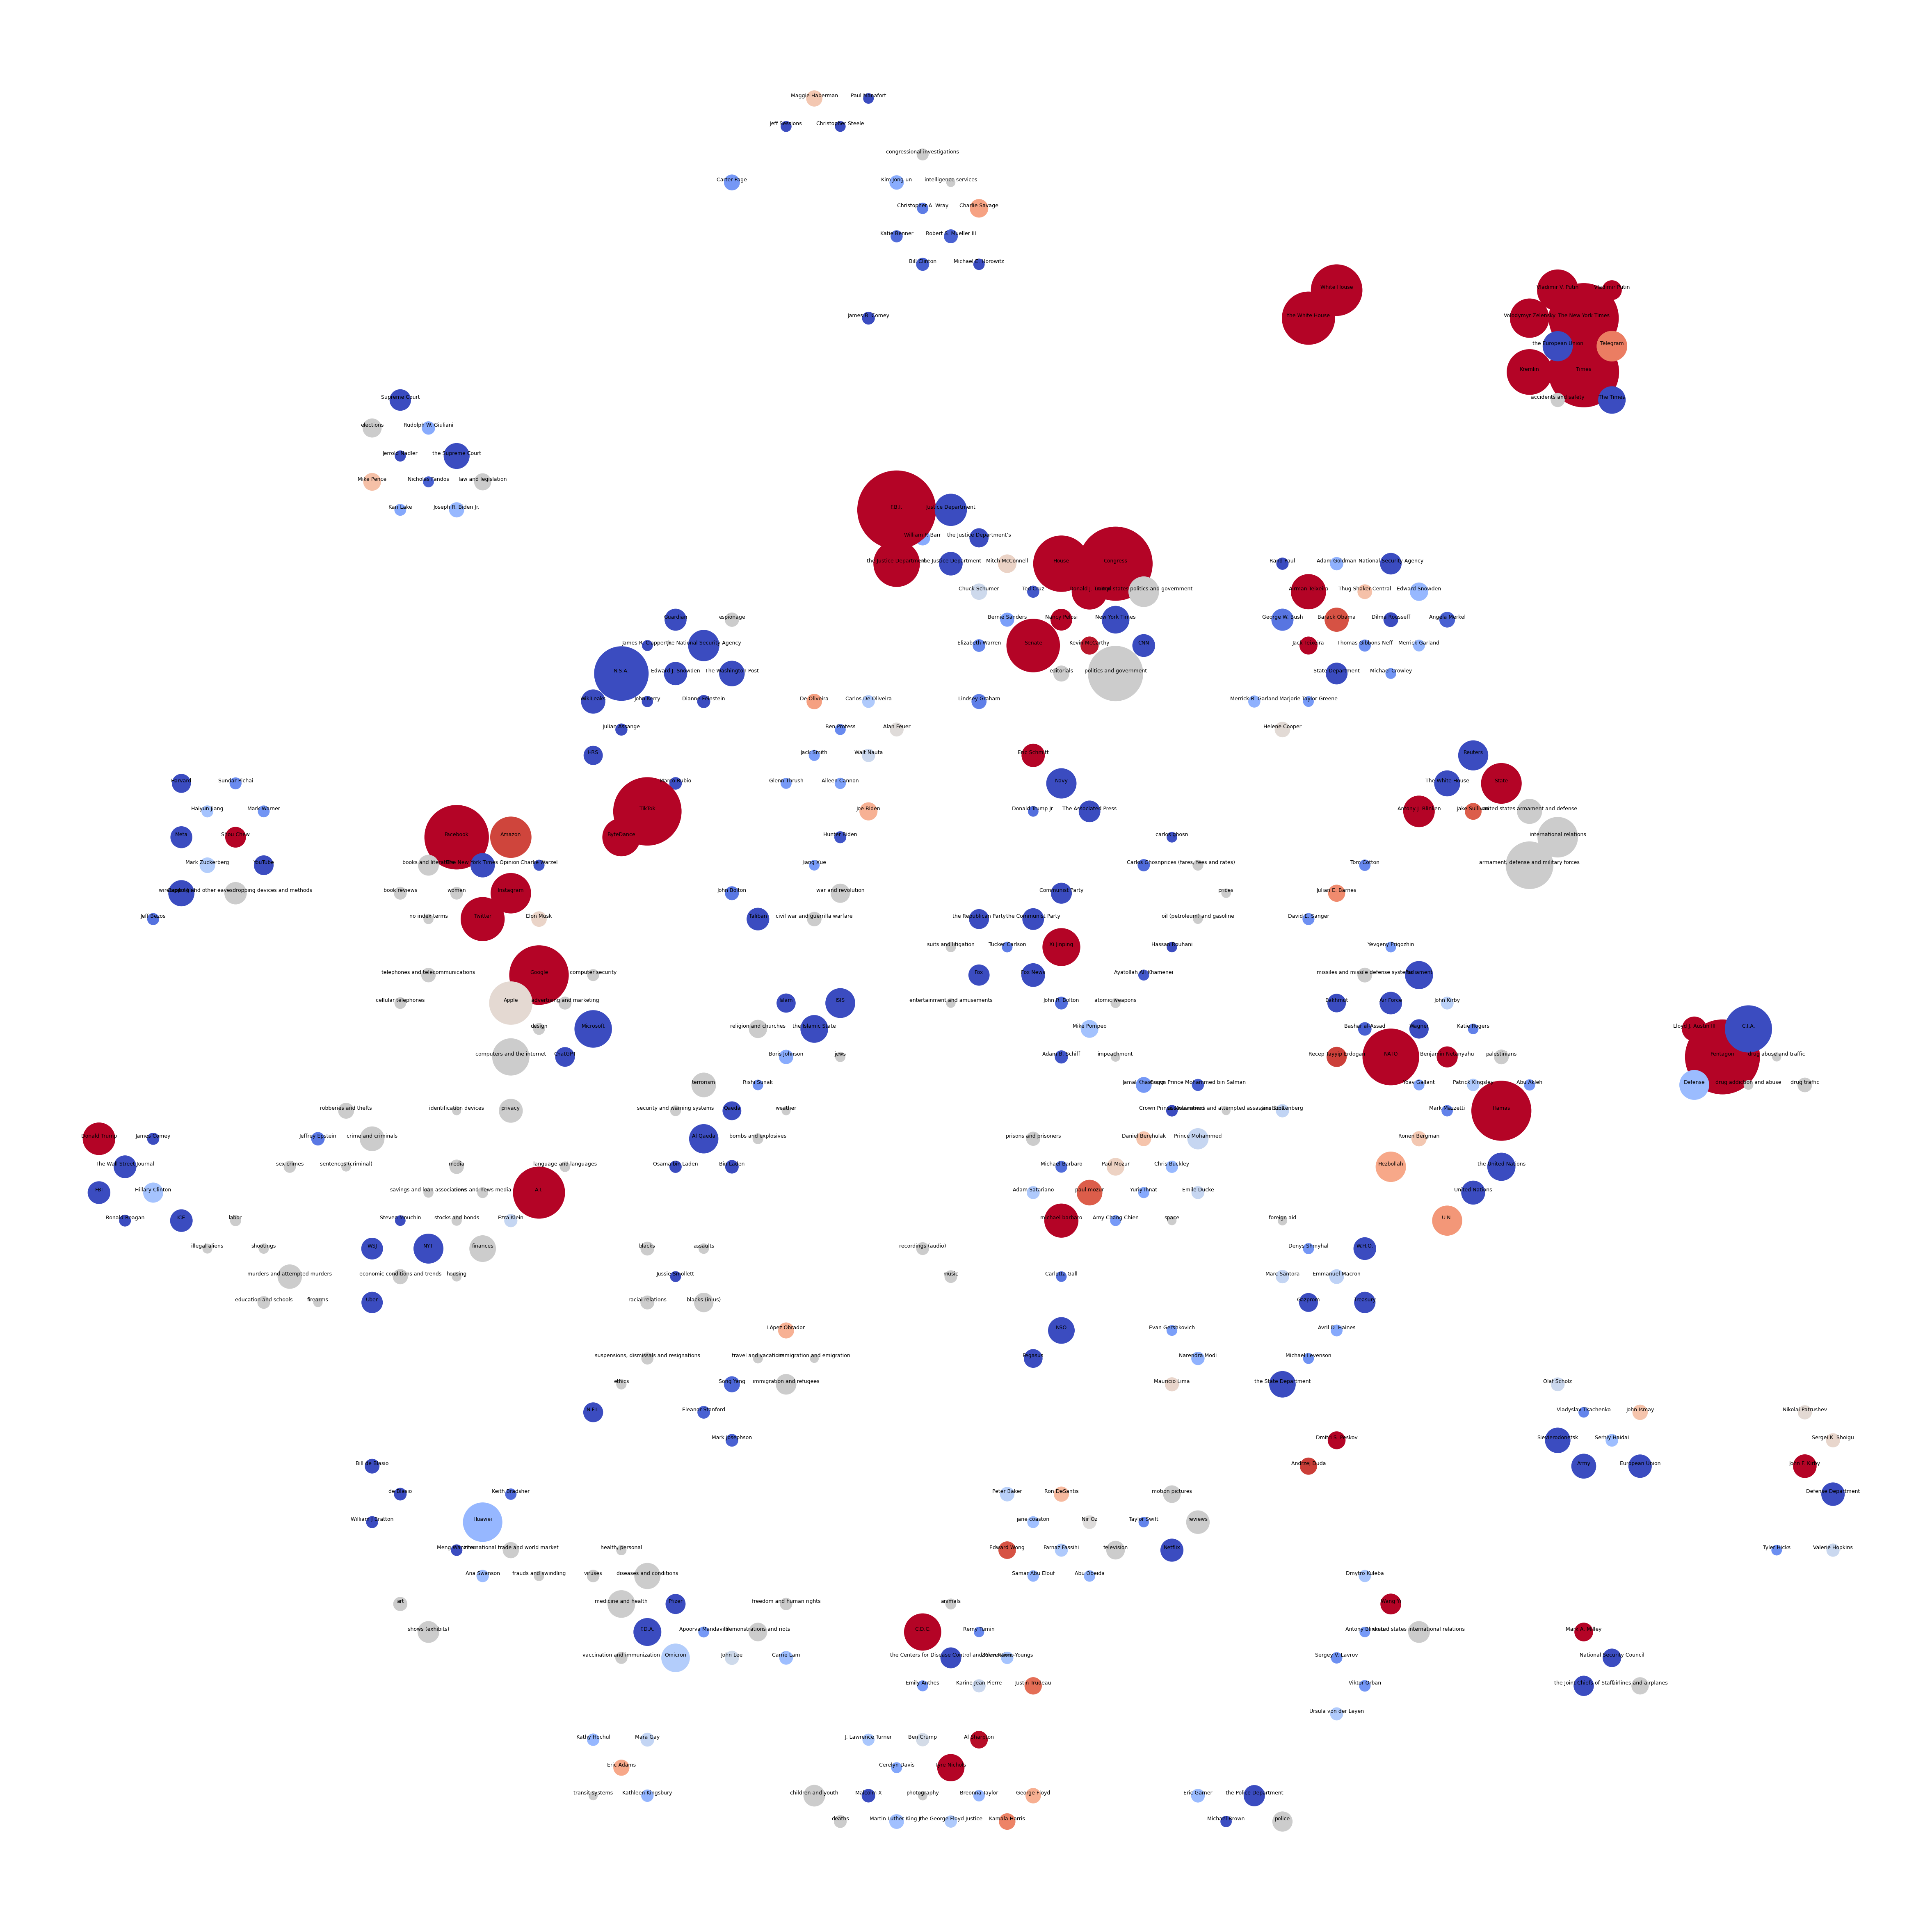

In [34]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [40]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=4,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
7740,W.H.O.,org,151,-3.309956,#3b4cc0,684,366,n_11,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2019/09/19/world/asia...,[Philippines Declares Polio Outbreak After 19 ...,"[Francisco Duque, Rabindra Abeyasinghe, Rodrig...",0.073892,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


{'n_0', 'p_2', 'n_7', 'n_5', 'n_11', 'n_3', 'p_3', 'n_8', 'n_12', 'n_6', 'n_19', 'p_4', 'n_1', 'n_16', 'n_14', '-1', 'p_0', 'n_10', 'p_1', 'n_2', 'n_15', 'n_18', 'n_9', 'p_5', 'n_17', 'n_13', 'n_4', 'n_20'}
8
15
5
10
10
7
9
21
13
12
12
12
13
18
13
75
9
11
23
8
9
5
20
12
6
31
5
8


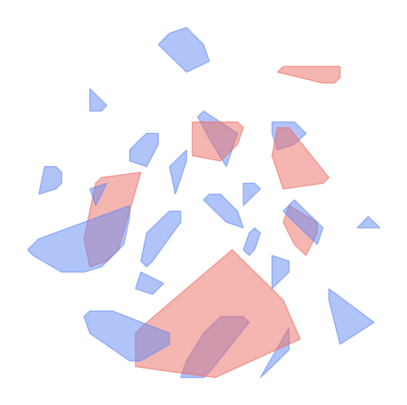

In [41]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [42]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
3335,Pegasus,org,99,-3.938527,#3b4cc0,531,315,-1,[https://www.nytimes.com/2019/03/21/us/politic...,0.048276,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."
